# Multi-class Classification of White Wine Quality with Support Vector Machine and Feature Union

## Wine Data
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citations
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
white_wine = pd.read_csv('../../ch_10/data/winequality-white.csv', sep=';')

## EDA

In [3]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
white_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.2 KB


Text(0, 0.5, 'quality score')

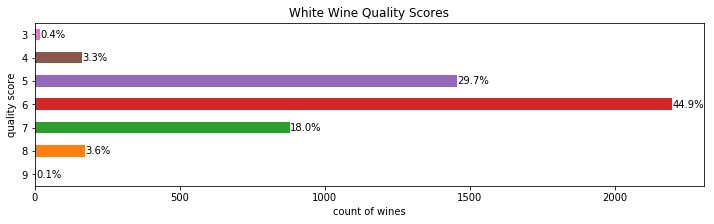

In [6]:
ax = white_wine.quality.value_counts().sort_index(
    ascending=False
).plot.barh(title='White Wine Quality Scores', figsize=(12, 3))
for bar in ax.patches:
    ax.text(
        bar.get_width(), 
        bar.get_y() + bar.get_height()/4, 
        f'{bar.get_width()/white_wine.shape[0]:.1%}'
    )
plt.xlabel('count of wines')
plt.ylabel('quality score')

## White wine quality multi-class classification

### Train test split

In [7]:
from sklearn.model_selection import train_test_split

y = white_wine.quality
X = white_wine.drop(columns=['quality'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=0, stratify=y
)

### Building model

In [8]:
%%capture --no-stdout
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFpr
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipeline = Pipeline([
    ('scale', StandardScaler()), 
    ('feature_union', FeatureUnion([('pca', PCA(random_state=0)), ('fpr', SelectFpr())])),
    ('svm', SVC(gamma='auto', random_state=0, probability=True))
])

search_space = {
    'feature_union__pca__n_components' : np.arange(2, 5),
    'svm__C' : [0.5, 1, 5]
}

grid = GridSearchCV(pipeline, search_space, scoring='f1_macro', cv=5).fit(X_train, y_train)

In [9]:
grid.best_params_

{'feature_union__pca__n_components': 3, 'svm__C': 5}

### Evaluating the model

In [10]:
preds = grid.predict(X_test)

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.62      0.21      0.31        24
           5       0.64      0.62      0.63       219
           6       0.57      0.77      0.65       330
           7       0.52      0.26      0.35       132
           8       0.40      0.08      0.13        26
           9       0.00      0.00      0.00         1

   micro avg       0.59      0.59      0.59       735
   macro avg       0.39      0.28      0.30       735
weighted avg       0.58      0.59      0.56       735



c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


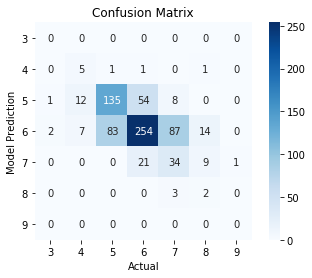

In [12]:
from ml_utils.classification import confusion_matrix_visual

confusion_matrix_visual(y_test, preds, np.sort(white_wine.quality.unique()))

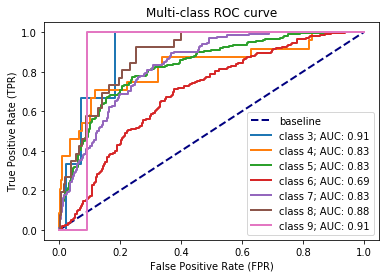

In [13]:
from ml_utils.classification import plot_multi_class_roc
plot_multi_class_roc(y_test, grid.predict_proba(X_test))